Reference Link: https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/ 

In [3]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import statsmodels.tsa.api as smt

In [4]:
def load_data(csv_name):  
    return pd.read_csv('csv files\\'+csv_name+'.csv')  


csv_name = 'monthlySales_ProdCode_67457437'
sales_data = load_data(csv_name)
sales_data.head()

,Unnamed: 0,date,sale_amount_per_item
0,0,2019-01-01,736632.00
1,1,2019-02-01,644280.00
2,2,2019-03-01,270503.99
3,3,2019-04-01,916344.00
4,4,2019-05-01,1565694.00


In [5]:
sales_data.shape

(24, 3)

In [6]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

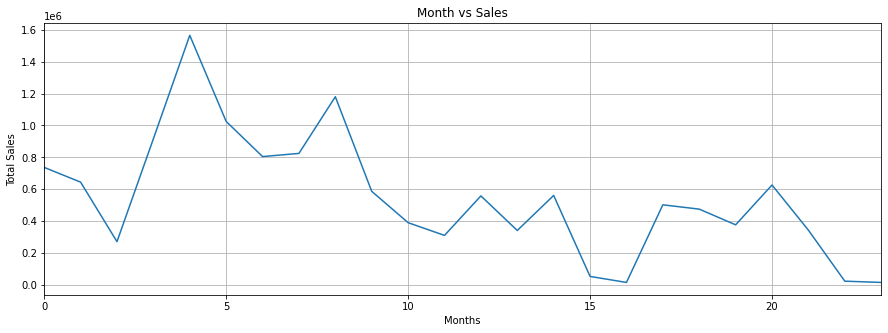

In [7]:
plt.title('Month vs Sales')
plt.ylabel('Total Sales')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(sales_data['sale_amount_per_item'])

Data Preprocessing

In [8]:
sales_data.columns

Index(['Unnamed: 0', 'date', 'sale_amount_per_item'], dtype='object')

In [9]:
all_data = sales_data['sale_amount_per_item'].values.astype(float)
print(all_data)

[ 736632.    644280.    270503.99  916344.   1565694.   1025544.
  804648.    824538.   1180296.    586481.98  389727.    309777.
  557817.    340860.    560664.     52299.     14508.    501851.98
  474747.    376271.99  626145.    342576.     22502.99   14625.  ]


In [10]:
test_data_size = 4

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

print(len(train_data))
print(len(test_data))
print(test_data)

20
4
[626145.   342576.    22502.99  14625.  ]


In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [12]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[-0.06893951]
 [-0.18801227]
 [-0.66993515]
 [ 0.16276965]
 [ 1.        ]]
[[-0.9512747 ]
 [-1.        ]
 [-0.37164985]
 [-0.40659727]
 [-0.53356465]]


In [13]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [14]:
train_window = 4

In [15]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [16]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [17]:
train_inout_seq

[(tensor([-0.0689, -0.1880, -0.6699,  0.1628]), tensor([1.])),
 (tensor([-0.1880, -0.6699,  0.1628,  1.0000]), tensor([0.3036])),
 (tensor([-0.6699,  0.1628,  1.0000,  0.3036]), tensor([0.0188])),
 (tensor([0.1628, 1.0000, 0.3036, 0.0188]), tensor([0.0444])),
 (tensor([1.0000, 0.3036, 0.0188, 0.0444]), tensor([0.5031])),
 (tensor([0.3036, 0.0188, 0.0444, 0.5031]), tensor([-0.2625])),
 (tensor([ 0.0188,  0.0444,  0.5031, -0.2625]), tensor([-0.5162])),
 (tensor([ 0.0444,  0.5031, -0.2625, -0.5162]), tensor([-0.6193])),
 (tensor([ 0.5031, -0.2625, -0.5162, -0.6193]), tensor([-0.2995])),
 (tensor([-0.2625, -0.5162, -0.6193, -0.2995]), tensor([-0.5792])),
 (tensor([-0.5162, -0.6193, -0.2995, -0.5792]), tensor([-0.2958])),
 (tensor([-0.6193, -0.2995, -0.5792, -0.2958]), tensor([-0.9513])),
 (tensor([-0.2995, -0.5792, -0.2958, -0.9513]), tensor([-1.])),
 (tensor([-0.5792, -0.2958, -0.9513, -1.0000]), tensor([-0.3716])),
 (tensor([-0.2958, -0.9513, -1.0000, -0.3716]), tensor([-0.4066])),
 (ten

In [15]:
train_inout_seq[:5]

[(tensor([-0.8125, -0.7066, -0.8150, -0.5515]), tensor([-0.6681])),
 (tensor([-0.7066, -0.8150, -0.5515, -0.6681]), tensor([-0.5186])),
 (tensor([-0.8150, -0.5515, -0.6681, -0.5186]), tensor([-0.8580])),
 (tensor([-0.5515, -0.6681, -0.5186, -0.8580]), tensor([-0.4684])),
 (tensor([-0.6681, -0.5186, -0.8580, -0.4684]), tensor([-0.4053]))]

In [16]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=10, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [17]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
print(model)

LSTM(
  (lstm): LSTM(1, 10)
  (linear): Linear(in_features=10, out_features=1, bias=True)
)


In [19]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.72563547
epoch:  26 loss: 1.09524155
epoch:  51 loss: 0.89526331
epoch:  76 loss: 0.61667234
epoch: 101 loss: 0.45960936
epoch: 126 loss: 0.35298702
epoch: 149 loss: 0.2732535005


Making Prediction

In [20]:
fut_pred = 4

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[-1.0, -0.5774030089378357, 0.04874366149306297, 0.7217666506767273]


In [21]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [22]:
test_inputs[fut_pred:]

[-0.05278649181127548,
 -0.46195298433303833,
 -0.9332152009010315,
 -1.1189064979553223]

In [23]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[ 1.24220287e+09]
 [ 7.25841236e+08]
 [ 1.31115781e+08]
 [-1.03223696e+08]]


In [24]:
x = np.arange(20, 24, 1)
print(x)

[20 21 22 23]


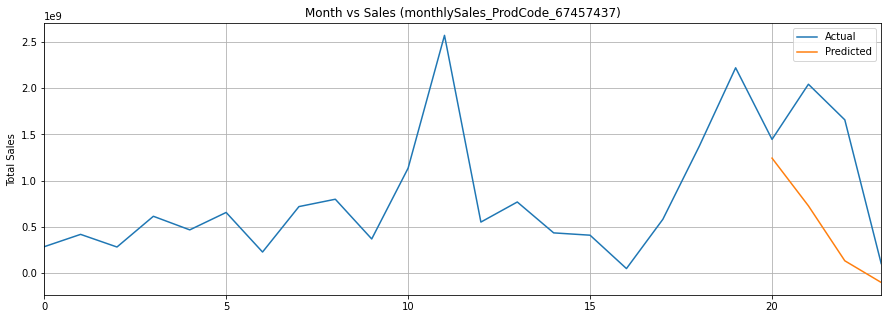

In [25]:
plt.title('Month vs Sales ('+csv_name+')')
plt.ylabel('Total Sales')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(sales_data['sale_amount_per_item'])
plt.plot(x,actual_predictions)
plt.legend(['Actual', 'Predicted'])
plt.savefig(csv_name+'_1.png')
plt.show()

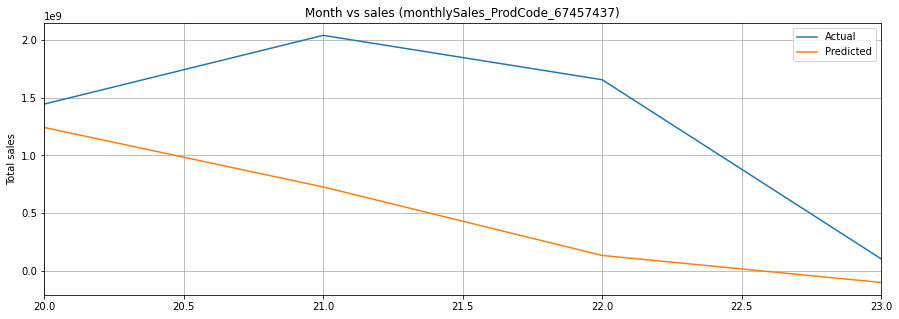

In [26]:
plt.title('Month vs sales ('+csv_name+')')
plt.ylabel('Total sales')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(sales_data['sale_amount_per_item'][-train_window:])
plt.plot(x,actual_predictions)
plt.legend(['Actual', 'Predicted'])
plt.savefig(csv_name+'_2.png')
plt.show()